# Display results POET AI Surrogate ML framework tests

In [56]:
import csv
# function to get EMA data for conducted experiments
def get_EMA_data(PID):
    power = {
        "load_data": {"GPU": 0, "CPU": 0},
        "setup": {"GPU": 0, "CPU": 0},
        "process_data": {"GPU": 0, "CPU": 0}
        }
    time = {
        "load_data": 0,
        "setup": 0,
        "process_data": 0
        }
    with open("output.EMA." + PID) as file:
        csv_reader = csv.reader(file, delimiter =",")
        next(csv_reader) # skip header row
        for i, row in enumerate(csv_reader):
            if row[6] == "NVIDIA A2":
                device = "GPU"
            elif "CPU-" in row[6]:
                device = "CPU"
            else:
                print("UNKNOWN EMA DEVICE!")
            power[row[1]][device] += int(row[7])
            if time[row[1]] == 0: # time is only taken from first device
                time[row[1]] = int(row[8])
        return [power, time]
    
def get_csv_data(PID, data, file_type = ""):
    try: # GPU files ony exist for jobs on GPU nodes, training history only for train jobs 
        with open("output." + data + "." + PID + file_type) as file:
            csv_reader = csv.reader(file, delimiter =",")
            return next(csv_reader)
    except OSError:
        return []

In [57]:
# read parameters and results of conducted experiments
experiments = {}
with open("experiments.csv") as file:
    csv_reader = csv.reader(file, delimiter =",")
    next(csv_reader) # skip header row
    for row in csv_reader:
        if row[0][0] == "#": # skip commented rows
            continue
        ema_data = get_EMA_data(row[4])
        experiments[row[4]] = {
            "framework": row[0],
            "task": row[1],
            "device": row[5],
            "model": row[2],
            "batch_size": int(row[3]),
            "power": ema_data[0], # in micro joules
            "time": ema_data[1], # in micro seconds
            "GPU_usage": [int(i) for i in get_csv_data(row[4], "GPU_usage")],  # percentage in 100 ms intervals
            "training_val_loss": [float(i) for i in get_csv_data(row[4], "training_history", ".csv")]
            }

## Training

In [58]:
training_experiments = {k:v for (k,v) in experiments.items() if v["task"] == "train"}

### Runtime

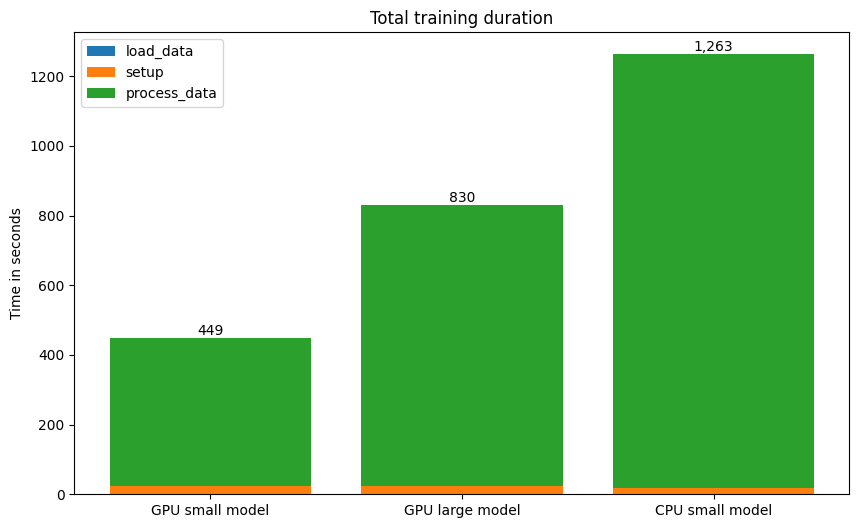

In [61]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

categories = ["load_data", "setup","process_data"]
n = len(training_experiments)
ind = range(n)
bars = [0] * n

for category in categories:
    values = [(d["time"][category]) // 1000000 for d in training_experiments.values()]
    ax.bar(ind, values, bottom=bars, label=category)
    bars = [b + v for b, v in zip(bars, values)]

ax.set_ylabel("Time in seconds")
ax.set_title("Total training duration")
ax.set_xticks(ind)
x_labels = [f"{d["device"]} {d["model"]} model" for d in training_experiments.values()]
ax.set_xticklabels(x_labels)
ax.legend()

# Add value labels on the bars
for i, total in enumerate(bars):
    ax.text(i, total, f"{total:,}", ha="center", va="bottom")
plt.show()

### Energy consumption

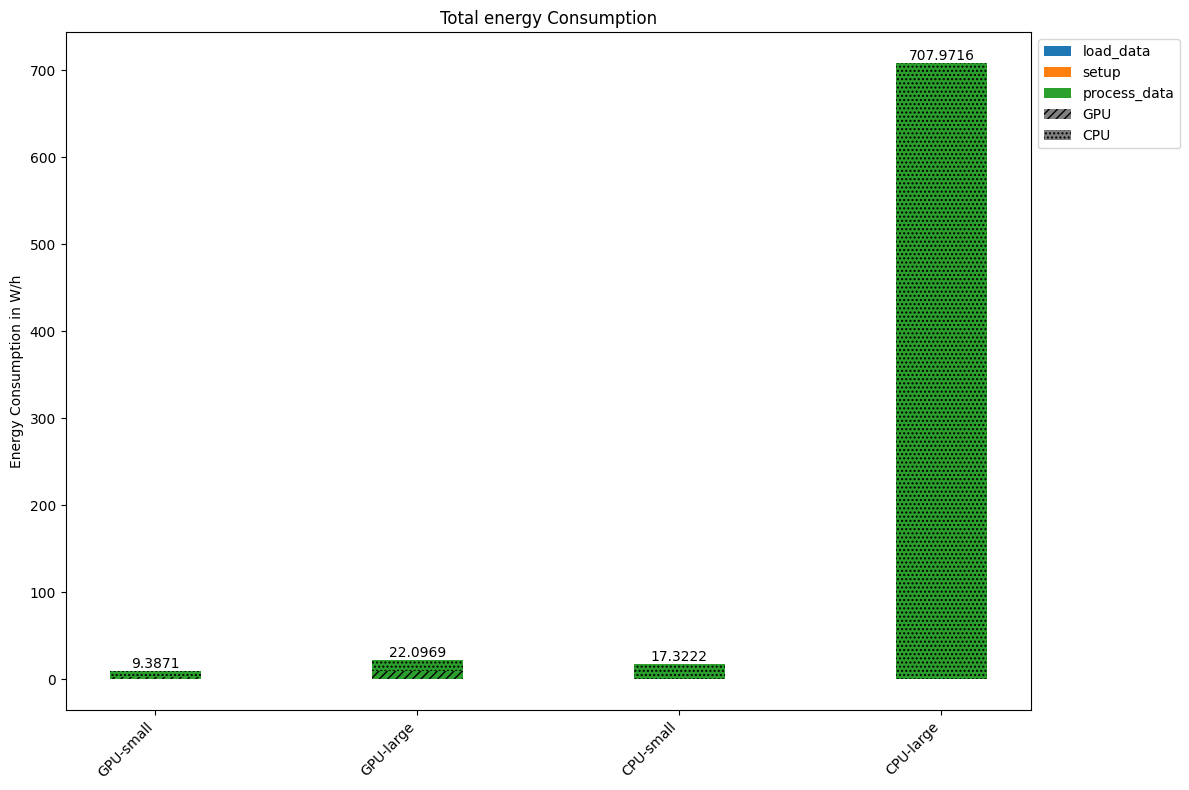

In [16]:
# Prepare data for plotting
categories = ["load_data", "setup","process_data"]
n = len(training_experiments)
ind = np.arange(n)
width = 0.35

# Define colors and hatches
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green
hatches = ["////", "...."]  # Diagonal lines for GPU and CPU

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

bars = np.zeros(n)
for i, category in enumerate(categories):
    gpu_values = [d["power"][category]["GPU"] / (1000000 * 3600) for d in training_experiments.values()]
    cpu_values = [d["power"][category]["CPU"] / (1000000 * 3600) for d in training_experiments.values()]
    
    ax.bar(ind, gpu_values, width, bottom=bars, color=colors[i], hatch=hatches[0])
    ax.bar(ind, cpu_values, width, bottom=bars+gpu_values, color=colors[i], hatch=hatches[1])
    
    bars += np.array(gpu_values) + np.array(cpu_values)

# Customize the plot
ax.set_ylabel("Energy Consumption in W/h")
ax.set_title("Total energy Consumption")
ax.set_xticks(ind)

# Create custom x-axis labels
x_labels = [f"{d["device"]}-{d["model"]}" for d in training_experiments.values()]
ax.set_xticklabels(x_labels, rotation=45, ha="right")

# Create custom legend
legend_elements = [
    mpatches.Patch(facecolor=colors[i], label=category) for i, category in enumerate(categories)
]
legend_elements.extend([
    mpatches.Patch(facecolor="gray", hatch=hatches[0], label="GPU"),
    mpatches.Patch(facecolor="gray", hatch=hatches[1], label="CPU")
])

ax.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1, 1))

# Add value labels on the bars
for i, total in enumerate(bars):
    ax.text(i, total, f"{total:,.4f}", ha="center", va="bottom")

plt.tight_layout()
plt.show()

### Accuracy

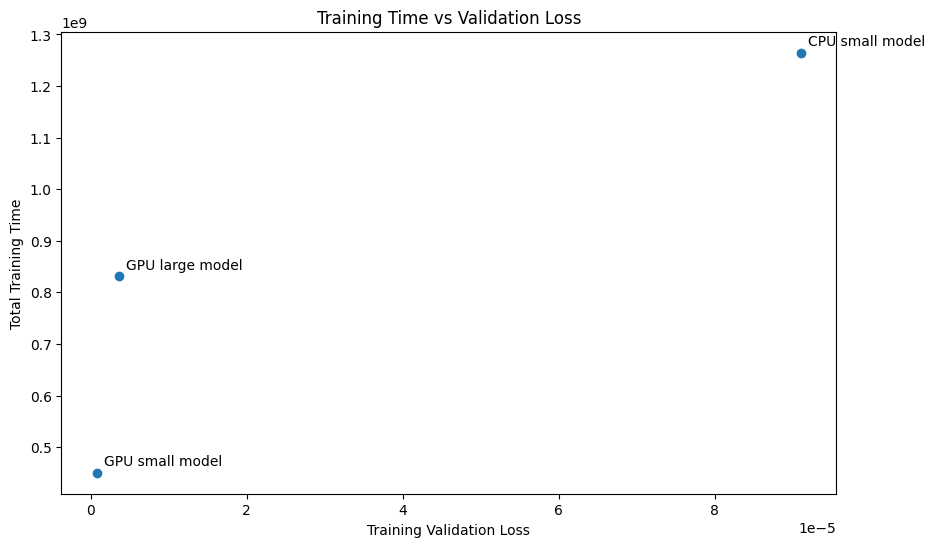

In [254]:
fig, ax = plt.subplots(figsize=(10, 6))
loss_values = []
training_times = []
labels = []

for key, item in training_experiments.items():
    loss_values.append(item["training_val_loss"][-1])
    training_times.append(sum(item["time"].values()))
    labels.append(f"{item["device"]} {item["model"]} model")

scatter = ax.scatter(loss_values, training_times)

ax.set_xlabel("Training Validation Loss")
ax.set_ylabel("Total Training Time")
ax.set_title("Training Time vs Validation Loss")

for i, label in enumerate(labels):
    ax.annotate(label, (loss_values[i], training_times[i]), xytext=(5, 5), 
                textcoords="offset points")
plt.show()

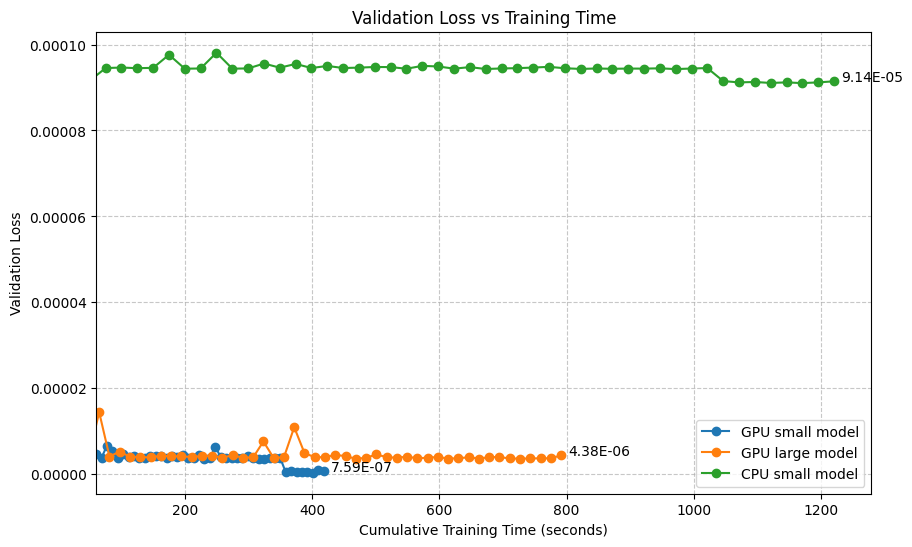

In [258]:
fig, ax = plt.subplots(figsize=(10, 6))
every_nth_epoch = 40
start_time = 60
end_time = None

for key, item in training_experiments.items():
    val_loss_history = item["training_val_loss"]
    # Calculate avg time per epoch
    processing_seconds = item["time"]["process_data"] / 1000000
    avg_time_per_epoch = processing_seconds / len(item["training_val_loss"])
    cumulative_time = [i * avg_time_per_epoch for i in range(len(val_loss_history))]

    # Plot the loss history in the given timeframe
    cumulative_time = np.array(cumulative_time)[::every_nth_epoch]
    val_loss_history = np.array(val_loss_history)[::every_nth_epoch]
    start_index = np.searchsorted(cumulative_time, int(start_time or 0), side="left")
    if start_index != 0:
        start_index -= 1

    end_index = np.searchsorted(cumulative_time, int(end_time or 1234567890), side="right")
    if end_index != len(cumulative_time):
        end_index += 1

    ax.plot(cumulative_time[start_index:end_index],
            val_loss_history[start_index:end_index],
            marker="o", label=f"{item["device"]} {item["model"]} model")

ax.set_xlabel("Cumulative Training Time (seconds)")
ax.set_ylabel("Validation Loss")
ax.set_xlim(start_time, end_time)
ax.set_title("Validation Loss vs Training Time")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.7)

# Show final loss values
for line in ax.get_lines():
    x = line.get_xdata()[-1]
    y = line.get_ydata()[-1]
    ax.annotate(f"{y:.2E}", xy=(x, y), xytext=(5, 0), textcoords="offset points")

plt.show()

### GPU usage

In [19]:
training_experiments_GPU = {k:v for (k,v) in training_experiments.items() if v["device"] == "GPU"}

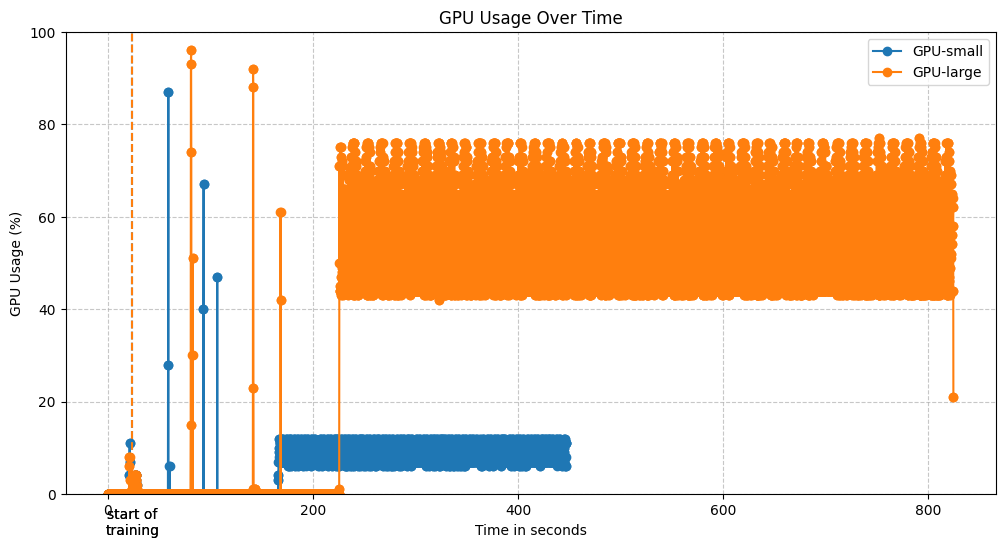

In [182]:
# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

every_nth_measurement = 1
sleep_interval = 100
start = None
stop = None

for key, item in training_experiments_GPU.items():
    start_time = None
    stop_index = None
    if start:
        start_time = int(start / (sleep_interval/1000))
    if stop:
        stop_index = int(stop / (sleep_interval/1000))
    gpu_usage = item["GPU_usage"][start_time:stop_index:every_nth_measurement]
    label = f"{item['device']}-{item['model']}"
    measured_timesteps = (len(gpu_usage) * every_nth_measurement)
    x_ticks = np.arange(int(start_time or 0), int(start_time or 0) + measured_timesteps) * (sleep_interval/1000)
    x_ticks = x_ticks[::every_nth_measurement]
    ax.plot(x_ticks, gpu_usage, marker='o', linestyle='-', label=label)

    # Calculate the start point of the training epochs
    training_start = (item["time"]["load_data"] + item["time"]["setup"]) / 1000000  # Convert to seconds
    if training_start >= int(start or 0) and training_start < int(stop or 1234567890):
        ax.axvline(x=training_start, color=ax.get_lines()[-1].get_color(), linestyle='--')
        # Add label on x-axis
        ax.text(training_start, -3, f"start of\ntraining", rotation=0, verticalalignment='top', 
                horizontalalignment='center', color="black")


# Set labels
ax.set_ylabel('GPU Usage (%)')
ax.set_xlabel('Time in seconds')
ax.set_title('GPU Usage Over Time')
ax.legend()

# Set y-axis to start from 0 and end at 100
ax.set_ylim(0, 100)

# Add a grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

plt.show()
